In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import geocoder
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',50)
pd.set_option('max_colwidth',200)
%matplotlib inline
import requests
import json
import urllib
from urllib.request import urlopen

def getGeoForAddress(address):
    add = urllib.parse.quote(address)
    addressUrl = "https://maps.googleapis.com/maps/api/geocode/json?address=" + add + '&key='
    res = requests.get(addressUrl)
    js = json.loads(res.text)
    if js.get('results'):
        lat = js.get('results')[0]['geometry']['location']['lat']
        lng = js.get('results')[0]['geometry']['location']['lng']
    else:
        lat = ''
        lng = ''
    return [lat, lng]
def ngram(text, n=3, pad=True):
    text = text.strip()
    if pad:
        text = " %s " % text
    return set([text[i:i+n] for i in range(len(text)-n+1)])
    
def create_ngram(text1, text2, n=3, pad=True):
    return ngram(text1, n=n, pad=pad), ngram(text2, n=n, pad=pad)

def tversky_index(text1, text2, a=None, b=None, q=3, pad=True):
    text1, text2 = create_ngram(text1, text2, n=q, pad=pad)
    agree_tot = len(text1.intersection(text2))
    v1 = len(text1) - agree_tot
    v2 = len(text2) - agree_tot
    
    if a != None and b != None:
        a = a/float(a+b)
        b = b/float(a+b)
    elif a <= 1.0 and a >= 0.0:
        b = 1-a
    elif b <= 1.0 and b >= 0.0:
        a = 1-b
    else:
        a = 0.5
        b = 0.5        
    return float(agree_tot)/(agree_tot+a*v1+b*v2)
# incoPat為申請人list
def fuzzy(incoPat,indus):
    corptype = ['有限','公司','责任','集团','股份','控股']
    text1 = incoPat
    text2 = indus
    incoPat_nor = []   
    for text in text1:
        for i in corptype:
            if i in text:
                text = re.sub(i,'',text)
        incoPat_nor.append(text)
    for i in corptype:
        if i in text2:
            text2 = re.sub(i,'',text2)
    similar = []
    for text in incoPat_nor:
        dice = tversky_index(text,text2, a=0.5, q=min(2,len(text),len(text2)), pad=False)
        if dice>0.7:
            similar.append([incoPat[incoPat_nor.index(text)],dice])
        else:
            pass
    if len(similar)>0:
        return similar[[k[1] for k in similar].index(max([i[1] for i in similar]))][0]
    else:
        return indus
city_code = pd.read_excel('C:/Users/user/Dropbox/paper/科技園區/China/省地縣碼對照.xls')
city_code = city_code[~city_code['代碼'].isnull()].drop(['标注','说明'],axis=1)
city_code['代碼_str'] = city_code['代碼'].apply(lambda x:str(int(x)))
city_code = city_code.drop('代碼',axis=1)

In [2]:
df1 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-黑龍江1.xls')
df2 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-黑龍江2.xls')
patent_df = pd.concat([df1,df2],ignore_index=True)

In [4]:
#for PC
patent_df = patent_df[patent_df['专利类型']=='发明授权']
patent_df = patent_df[patent_df['申请人地址'].map(lambda x:len(re.findall(r'\D+[\s\S]+',x)))==1]
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.findall(r'\D+[\s\S]+',x)[0])
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.sub(r"\s+", "",x))
patent_df_firm = patent_df[patent_df['申请人类型'].str.contains('企业')]
applicant = patent_df_firm['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
patent_df_firm = patent_df_firm.join(applicant)
patent_df_firm['類別'] = patent_df_firm['申请人类型'].map(lambda x:x.strip().split('  '))
patent_df_firm = patent_df_firm[~patent_df_firm['标题'].duplicated()]
patent_df_firm['申请人类型'] = patent_df_firm.apply(lambda x:x['類別'][0],axis=1)
patent_df_firm = patent_df_firm[patent_df_firm['申请人类型']=='企业'].sort_values('申请日')
patent_df_firm.drop(['類別','申请人'],axis=1,inplace=True)
patent_df_firm.rename(columns={'申请人2':'申请人'},inplace=True)
patent_df_firm = patent_df_firm[patent_df_firm['申请日']<datetime.datetime.strptime('2013-01-01','%Y-%m-%d')]
patent_df_firm.drop_duplicates('申请人地址', keep='last', inplace=True)
patent_df_firm.drop_duplicates('申请人', keep='last', inplace=True)

firm_df = pd.read_csv(r'E:\paper\Firm csv\firm_data_2012.csv')
firm_hlj = firm_df[firm_df['區域代碼'].astype(str).str.contains(r'23\d{10}')==True]
firm_hlj = firm_hlj.loc[:,['法人代碼','企業名稱','地址','區域代碼','行業代碼']]
firm_hlj['區域代碼_str'] = firm_hlj['區域代碼'].astype(str).map(lambda x:x[0:6])
firm_hlj = pd.merge(firm_hlj,city_code,left_on='區域代碼_str',right_on='代碼_str',how='left')
firm_hlj['名稱'].fillna('',inplace=True)
firm_hlj['市級'].fillna('',inplace=True)
firm_hlj['省份'].fillna('',inplace=True)
firm_hlj['地址'].fillna('',inplace=True)
firm_hlj['地址'] = firm_hlj['地址'].map(lambda x:re.sub(r"\s+", "",x))
firm_hlj['地址'] = firm_hlj.apply(lambda x:re.sub(x['省份'],"",x['地址']),axis=1)
firm_hlj['地址'] = firm_hlj.apply(lambda x:re.sub(x['市級'],"",x['地址']),axis=1)
firm_hlj['地址'] = firm_hlj.apply(lambda x:re.sub(x['名稱'],"",x['地址']),axis=1)
firm_hlj['地址'] = firm_hlj['省份']+firm_hlj['市級']+firm_hlj['名稱']+firm_hlj['地址']
firm_hlj.drop(['省份','市級','名稱','代碼_str'],axis=1,inplace=True)
firm_hlj.dropna(subset=['企業名稱'],inplace=True)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,3,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
patent_df_firm

,序号,标题,文献页数,合享价值度,链接到incoPat,公开（公告）号,公开（公告）日,申请号,申请日,申请人,标准化申请人,申请人国别代码,申请人省市代码,中国申请人地市,中国申请人区县,申请人地址,申请人类型,优先权信息,权利要求数量,专利类型,发明人,IPC,CPC,简单同族,扩展同族,inpadoc同族,同族国家,简单同族个数,扩展同族个数,inpadoc同族个数,引证专利,被引证专利,被引证次数,引证科技文献,专利寿命（月）,被引证国别(forward),失效日,公开国别
72393,12394,桥梁箱梁底部钢绞线张拉限位装置,6,8,到incoPat中查看\r\nCN201183289Y,CN201183289Y,2009-01-21,CN200820089015.X,2008-01-04,中铁十三局集团有限公司,[中国铁建-C],中国,黑龙江; 23,[哈尔滨],[南岗],黑龙江省哈尔滨市南岗区先锋路459号四公司转,企业,CN200820089015 20080104,5,实用新型,吴宝喜,B28B23/04,NaN,CN201183289Y,CN201183289Y,CN201183289Y,CN,1,1,1,NaN,NaN,0,NaN,120.0,NaN,2018-01-04,CN
72397,12398,电梯曳引机承重梁封头装置,6,4,到incoPat中查看\r\nCN201183700Y,CN201183700Y,2009-01-21,CN200820089070.9,2008-01-08,齐齐哈尔西格玛电梯安装有限公司,NaN,中国,黑龙江; 23,[齐齐哈尔],[龙江],黑龙江省齐齐哈尔市新明大街25号1号楼3单元101室,企业,CN200820089070 20080108,1,实用新型,徐云彻; 孔建伟,B66B11/00,NaN,CN201183700Y,CN201183700Y,CN201183700Y,CN,1,1,1,NaN,NaN,0,NaN,96.0,NaN,2016-01-08,CN
55895,55896,井管的制作方法,7,8,到incoPat中查看\r\nCN101486227B,CN101486227B,2011-11-23,CN200810000508.6,2008-01-18,哈尔滨三元水工业科技发展有限责任公司,NaN,中国,黑龙江; 23,[哈尔滨],[道外],黑龙江省哈尔滨市道外区太古街133号,企业,NaN,5,发明授权,徐建国,B28B21/24; B28B21/34,NaN,CN101486227B; CN101486227A,CN101486227A; CN101486227B,CN101486227B; CN101486227A,CN,2,2,2,CN2712588Y; CN1048188A; US4079500A; DE2019565A1; DE2228882A1,NaN,0,NaN,96.0,NaN,2016-01-18,CN
72820,12821,快速定位锁紧联动装置,5,7,到incoPat中查看\r\nCN201165210Y,CN201165210Y,2008-12-17,CN200820089117.1,2008-01-18,航天科工哈尔滨风华有限公司航天产品分公司,NaN,中国,黑龙江; 23,[哈尔滨],[南岗],黑龙江省哈尔滨市南岗区中山路115号哈尔滨市90信箱40分箱,企业,CN200820089117 20080118,2,实用新型,肖波; 施晶; 郭君; 王宏鹏,B60P7/15,NaN,CN201165210Y,CN201165210Y,CN201165210Y,CN,1,1,1,NaN,CN102431716A,1,NaN,60.0,中国,2013-01-18,CN
73058,13059,一种布匹裁条机,5,2,到incoPat中查看\r\nCN201155063Y,CN201155063Y,2008-11-26,CN200820089156.1,2008-01-19,大庆市三环钻井工程有限公司,NaN,中国,黑龙江; 23,[大庆],[萨尔图],黑龙江省大庆市萨尔图区东风新村经三街169号,企业,CN200820089156 20080119,2,实用新型,杨晶才,D06H7/00,NaN,CN201155063Y,CN201155063Y,CN201155063Y,CN,1,1,1,NaN,NaN,0,NaN,25.0,NaN,2010-02-20,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8881,8882,井口水过滤器,5,7,到incoPat中查看\r\nCN204364991U,CN204364991U,2015-06-03,CN201420861742.9,2014-12-31,牡丹江博实石油机械科技有限公司,NaN,中国,黑龙江; 23,[牡丹江],[东安],黑龙江省牡丹江市东安区东七条路新安街木工机械厂院内,企业,NaN,6,实用新型,马中原; 高风启; 汪斌; 王大彪; 周健,B01D29/33,NaN,CN204364991U,CN204364991U,CN204364991U,CN,1,1,1,NaN,NaN,0,NaN,NaN,NaN,NaT,CN
2565,2566,高效禽类骨肉分离机,5,7,到incoPat中查看\r\nCN104542881B,CN104542881B,2016-09-14,CN201410850231.1,2014-12-31,齐齐哈尔双百机械制造有限公司,NaN,中国,黑龙江; 23,[齐齐哈尔],[昂昂溪],黑龙江省齐齐哈尔市昂昂溪区金水二街58号,企业,NaN,1,发明授权,张百春; 王中秋,A22C21/00,NaN,CN104542881A; CN104542881B,CN104542881A; CN104542881B,CN104542881A; CN104542881B,CN,2,2,2,NaN,NaN,0,NaN,NaN,NaN,NaT,CN
9544,9545,一种免驱动Android软件户外推广设备,5,8,到incoPat中查看\r\nCN204347821U,CN204347821U,2015-05-20,CN201420859886.0,2014-12-31,哈尔滨安天科技股份有限公司,[安天科技-C],中国,黑龙江; 23,[哈尔滨],[南岗],黑龙江省哈尔滨市开发区南岗集中区红旗大街162号506室,企业,NaN,3,实用新型,宛宏祥; 黄显澍; 桑胜田,G06F9/44; G06F9/445,NaN,CN204347821U,CN204347821U,CN204347821U,CN,1,1,1,NaN,NaN,0,NaN,NaN,NaN,NaT,CN
174,175,车用电子喇叭的发声方法,7,7,到incoPat中查看\r\nCN104538015B,CN104538015B,2018-07-10,CN201410846994.9,2014-12-31,哈尔滨固泰电子有限责任公司,NaN,中国,黑龙江; 23,[哈尔滨],[平房],黑龙江省哈尔滨市平房区大连北路1号,企业,NaN,2,发明授权,赵宏伟,G10K9/13,NaN,CN104538015B; CN104538015A,CN104538015B; CN104538015A,CN104538015A; CN104538015B,CN,2,2,2,CN204288792U; CN1427393A; CN103745716A; CN200947672Y,NaN,0,NaN,NaN,NaN,NaT,CN


In [9]:
firm_hlj

,法人代碼,企業名稱,地址,區域代碼,行業代碼,區域代碼_str
0,00176423X,肇源县电业局,黑龙江省大庆市肇源县中央大街,230622100007,4420,230622
1,05285143X,大庆市艾路交通设施有限公司,黑龙江省大庆市萨尔图区拥军大街标杆村,230602008004,3792,230602
2,05286322X,海林市宏泰木业有限公司,黑龙江省牡丹江市海林市柴河林业局铁东路97号,231083404002,2440,231083
3,100049039,大庆市让胡路区建民预制厂,黑龙江省大庆市让胡路区西虹2路,230604004007,3122,230604
4,126970993,黑龙江省电力有限公司,黑龙江省哈尔滨市南岗区汉水路301号,230103018007,4420,230103
...,...,...,...,...,...,...
3711,79504644X,海林市盛佳木制品有限公司,黑龙江省牡丹江市海林市海林镇斗银路,231083100002,2012,231083
3712,795047485,齐齐哈尔金同油田开发有限责任公司,黑龙江省齐齐哈尔市富拉尔基区燕北,230206001007,710,230206
3713,795047741,牡丹江天马水泥有限公司,黑龙江省牡丹江市宁安市工业路33号,231084001006,3111,231084
3714,795048306,黑河市元泰硅业有限公司,黑龙江省黑河市爱辉区合作区,231102001017,3199,231102


In [ ]:
patent_df_firm = patent_df_firm[patent_df_firm['申请日']>datetime.datetime.strptime('2007-12-31','%Y-%m-%d')]
incoPat = list(patent_df_firm['申请人'])

In [12]:
firm_hlj['name_模糊比對'] = firm_hlj['企業名稱'].map(lambda x:fuzzy(incoPat,x))

In [13]:
firm_hlj.to_excel(r'E:\paper\清理結果-新型&授權\黑龍江_廠商.xlsx')

# 非模糊比對

In [14]:
merge_df = firm_hlj.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)

In [16]:
merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape

(455, 45)

In [20]:
merge_df.shape

(5469, 47)

In [17]:
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_clean = merge_df[merge_df['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0

D:\Anaconda\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A

In [27]:
merge_df_clean[merge_df_clean['完整地址']==1].shape

(2112, 50)

In [28]:
merge_df_clean.shape

(4099, 50)

In [29]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新型&授權\黑龍江_結果.xlsx')

# merge舊資料

In [6]:
merge_df = firm_hlj.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df = merge_df[merge_df['address']!='']
merge_df_clean = merge_df
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(226, 44)
(4318, 44)
(1319, 49)
(4318, 49)


In [7]:
done_data = pd.read_excel(r'E:\paper\清理結果-園區內外\黑龍江_結果.xlsx')
done_data.columns

Index(['Unnamed: 0', '法人代碼', '企業名稱', '地址', '區域代碼', '行業代碼', '區域代碼_str',
       'name_模糊比對', '序号', '标题', '文献页数', '合享价值度', '链接到incoPat', '公开（公告）号',
       '公开（公告）日', '申请号', '申请日', '申请人', '标准化申请人', '申请人国别代码', '申请人省市代码',
       '中国申请人地市', '中国申请人区县', '申请人地址', '申请人类型', '优先权信息', '权利要求数量', '专利类型',
       '发明人', 'IPC', 'CPC', '简单同族', '扩展同族', 'inpadoc同族', '同族国家', '简单同族个数',
       '扩展同族个数', 'inpadoc同族个数', '引证专利', '被引证专利', '被引证次数', '引证科技文献', '专利寿命（月）',
       '被引证国别(forward)', '失效日', '公开国别', 'name', 'address', '完整地址', 'lat',
       'lnt', '哈爾濱', '大慶', '齊齊哈爾', '專利數', '早期園區', '近期園區'],
      dtype='object')

In [8]:
merge_df_clean.drop(['lat','lnt'],axis=1,inplace=True)
merge_df_clean = merge_df_clean.merge(done_data[['name','lat','lnt','哈爾濱','大慶','齊齊哈爾','專利數','早期園區','近期園區']],left_on='name',right_on='name',how='left')
merge_df_clean['lat'].fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(1437, 55)

In [9]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\黑龍江_結果.xlsx')

# 模糊比對

In [22]:
merge_df_fuzzy = firm_hlj.merge(patent_df_firm,left_on='name_模糊比對',right_on='申请人',how='outer')
merge_df_fuzzy.fillna('',inplace=True)
merge_df_fuzzy.drop_duplicates(['name_模糊比對','申请人'], keep='last', inplace=True)

In [23]:
merge_df_fuzzy[(merge_df_fuzzy['申请人']!='')&(merge_df_fuzzy['企業名稱']!='')].shape

(512, 45)

In [24]:
merge_df_fuzzy.shape

(5387, 45)

In [25]:
merge_df_fuzzy['name'] = merge_df_fuzzy.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df_fuzzy['address'] = merge_df_fuzzy.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_fuzzy_clean = merge_df_fuzzy[merge_df_fuzzy['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_fuzzy_clean['address'] = merge_df_fuzzy_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_fuzzy_clean['完整地址'] = merge_df_fuzzy_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_fuzzy_clean.loc[:,'lat'] = 0
merge_df_fuzzy_clean.loc[:,'lnt'] = 0

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [32]:
merge_df_fuzzy_clean[merge_df_fuzzy_clean['完整地址']==1].shape

(2072, 50)

In [33]:
merge_df_fuzzy_clean.shape

(4031, 50)

In [30]:
merge_df_fuzzy_clean.to_excel(r'E:\paper\清理結果-新型&授權\黑龍江_模糊結果.xlsx')

# 定位

In [2]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新型&授權\黑龍江_結果.xlsx',index_col=0)
merge_df_clean['lat'].fillna(0,inplace=True)
merge_df_clean['lnt'].fillna(0,inplace=True)

In [3]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新\黑龍江_結果.xlsx',index_col=0)
merge_df_clean.fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(1437, 55)

In [4]:
for i in merge_df_clean[merge_df_clean['lat']==''].index:
    address = merge_df_clean.loc[i,'address']
    g = getGeoForAddress(address)
    merge_df_clean.loc[i,'lat'] = g[0]
    merge_df_clean.loc[i,'lnt'] = g[1]

In [5]:
print(merge_df_clean.shape)
print(merge_df_clean[merge_df_clean['lat']==''].shape)

(4318, 55)
(15, 55)


In [6]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\黑龍江_結果.xlsx')

# 作圖

In [ ]:
from geopy.distance import geodesic
def how_far(a,b):
    try:
        return geodesic(a,b).kilometers
    except:
        return np.nan
applicant = patent_df['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
applicant = applicant.map(lambda x:x.strip())
patent_df_new = patent_df.join(applicant)
patent_count = patent_df_new.groupby('申请人2')['标题'].count().rename('專利數')

In [ ]:
patent_count.sort_values()

In [ ]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新型&授權\黑龍江_結果.xlsx',index_col=0)
target1 = (45.74567,126.69181)
merge_df['哈爾濱'] = merge_df.apply(lambda x:how_far(target1,(x['lat'],x['lnt'])),axis=1)
target2 = (46.57246,125.14284)
merge_df['大慶'] = merge_df.apply(lambda x:how_far(target2,(x['lat'],x['lnt'])),axis=1)
target3 = (47.30816,123.95543)
merge_df['齊齊哈爾'] = merge_df.apply(lambda x:how_far(target3,(x['lat'],x['lnt'])),axis=1)
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [ ]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新\黑龍江_結果.xlsx',index_col=0)
merge_df.fillna('',inplace=True)
merge_df.drop('專利數',axis=1,inplace=True)
target1 = (45.74567,126.69181)
target2 = (46.57246,125.14284)
target3 = (47.30816,123.95543)

for i in merge_df[merge_df['哈爾濱']==''].index:
    merge_df.loc[i,'哈爾濱'] = how_far(target1,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'大慶'] = how_far(target2,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'齊齊哈爾'] = how_far(target3,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [ ]:
merge_df['早期園區'] = merge_df.apply(lambda x:1 if ((x['哈爾濱']<10)or(x['大慶']<10)) else 0,axis=1)
merge_df['近期園區'] = merge_df.apply(lambda x:1 if (x['齊齊哈爾']<10) else 0,axis=1)

In [ ]:
merge_df.to_excel(r'E:\paper\清理結果-新園區內外\黑龍江_結果.xlsx')

In [ ]:
print(merge_df.shape)
print(len(merge_df[merge_df['專利數']==0]['專利數'])/len(merge_df['專利數']))
print(len(merge_df[merge_df['專利數']>=100]['專利數'])/len(merge_df['專利數']))

In [ ]:
merge_df.groupby('專利數')['IPC'].count()

In [ ]:
merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count()

In [ ]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count())
ax1.set_title('黑龍江',fontproperties=myfont,fontsize=15)
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)
ax1.set_xlim([0,100])
ax1.set_ylim([0,400])
ax2 = ax1.twinx()
ax2.bar(merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count(),color='red')
ax2.set_ylim([0,20])
ax2.set_ylabel('無法定位廠商數量',fontproperties=myfont)

In [ ]:
region = pd.read_excel(r'E:\paper\清理結果-新園區內外\黑龍江_結果.xlsx',index_col=0)
region.fillna('',inplace=True)
corptype = ['有限','责任','集团','股份','控股','总公司','分公司','公司']
region['name_clean'] = region['name']
for k in corptype:
    region['name_clean'] = region['name_clean'].map(lambda x:re.sub(k,'',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'[\s+-─]','',x))
clean = region[region.duplicated(['name_clean'],keep=False)].sort_values(by=['企業名稱'])
patents = clean.groupby('name_clean')['專利數'].sum()
final = clean.drop('專利數',axis=1).merge(patents,left_on='name_clean',right_on='name_clean',how='left')
final.drop_duplicates(['name_clean'],keep='last',inplace=True)
region.drop_duplicates(['name_clean'],keep=False,inplace=True)
cleaned = pd.concat([region,final],ignore_index=True,sort=False)
located = cleaned[cleaned['lat']!='']
not_merge = located[located['企業名稱']=='']
print(len(not_merge['專利數']))
print(len(not_merge['專利數'])/len(located['專利數']))
print(len(not_merge[not_merge['專利數']>100]['專利數']))

In [ ]:
not_merge.groupby('專利數')['IPC'].count()

In [ ]:
not_merge[not_merge['專利數']>=100].sort_values('專利數')

In [ ]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(not_merge.groupby('專利數')['IPC'].count().index,not_merge.groupby('專利數')['IPC'].count())
ax1.set_title('黑龍江',fontproperties=myfont,fontsize=15)
ax1.set_xlim([0,100])
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)

In [ ]:
cleaned.to_excel(r'E:\paper\名稱merge\黑龍江_結果.xlsx')

In [ ]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, merge_df[merge_df['早期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['早期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, merge_df[merge_df['近期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['近期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), '%.0f' % merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  

plt.title('黑龍江',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper left',prop=myfont)

In [ ]:
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts/Firms ')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), '%.0f' % (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  

plt.title('黑龍江',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper right',prop=myfont)

# 其餘嘗試性作圖

In [111]:
from matplotlib.patches import Ellipse, Circle
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
merge_df_clean.fillna('',inplace=True)
patented = merge_df_clean[merge_df_clean['申请人']!='']
not_patented = merge_df_clean[merge_df_clean['申请人']=='']

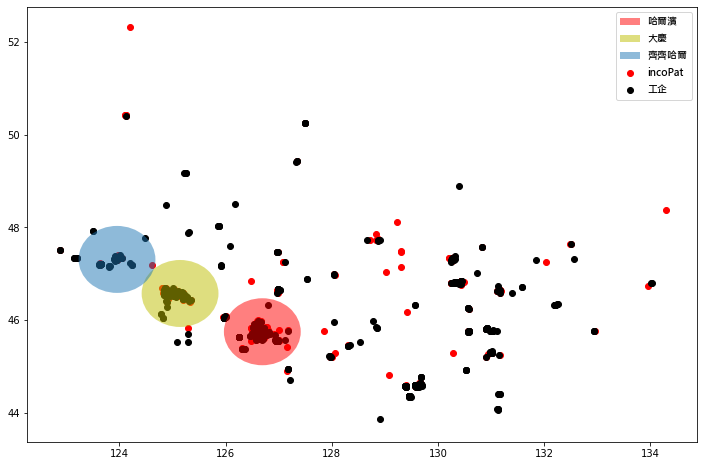

In [112]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(patented['lnt'], patented['lat'],c='r',label='incoPat')
ax.scatter(not_patented['lnt'], not_patented['lat'],c='k',label='工企')
cir1 = Circle(xy = (126.69181, 45.74567), radius=80/110.574,facecolor='r' ,alpha=0.5,label='哈爾濱')
cir2 = Circle(xy = (125.14284, 46.57246), radius=80/110.574,facecolor='y' ,alpha=0.5,label='大慶')
cir3 = Circle(xy = (123.95543, 47.30816), radius=80/110.574, alpha=0.5,label='齊齊哈爾')
ax.add_patch(cir1)
ax.add_patch(cir2)
ax.add_patch(cir3)
ax.legend(loc=1,prop=myfont)

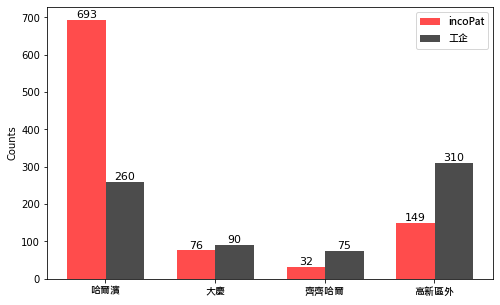

In [113]:
fig = plt.figure(figsize = (8,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Counts')
bar1 = ax1.bar(np.arange(0,4),[len(patented[patented['哈爾濱']==1]),len(patented[patented['大慶']==1]),len(patented[patented['齊齊哈爾']==1]),len(patented[(patented['哈爾濱']==0)&(patented['大慶']==0)&(patented['齊齊哈爾']==0)])],alpha=0.7,width=0.35,color='r',label='incoPat')
bar2 = ax1.bar(np.arange(0,4)+0.35,[len(not_patented[not_patented['哈爾濱']==1]),len(not_patented[not_patented['大慶']==1]),len(not_patented[not_patented['齊齊哈爾']==1]),len(not_patented[(not_patented['哈爾濱']==0)&(not_patented['大慶']==0)&(not_patented['齊齊哈爾']==0)])],alpha=0.7,width=0.35,color='k',label='工企')
for a,b in zip(np.arange(0,4),[len(patented[patented['哈爾濱']==1]),len(patented[patented['大慶']==1]),len(patented[patented['齊齊哈爾']==1]),len(patented[(patented['哈爾濱']==0)&(patented['大慶']==0)&(patented['齊齊哈爾']==0)])]):  
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=11)  
for a,b in zip(np.arange(0,4)+0.35,[len(not_patented[not_patented['哈爾濱']==1]),len(not_patented[not_patented['大慶']==1]),len(not_patented[not_patented['齊齊哈爾']==1]),len(not_patented[(not_patented['哈爾濱']==0)&(not_patented['大慶']==0)&(not_patented['齊齊哈爾']==0)])]):  
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=11) 

plt.xticks([0.17,1.17,2.17,3.17],['哈爾濱','大慶','齊齊哈爾','高新區外'],fontproperties=myfont)
plt.legend(handles = [bar1,bar2], loc='upper right',prop=myfont)

In [ ]:
patented['哈爾濱'] = patented.apply(lambda x:1 if ((((x['lnt']-126.69181)**2)+((x['lat']-45.74567)**2))**0.5)<(80/110.574) else 0,axis=1)
patented['大慶'] = patented.apply(lambda x:1 if ((((x['lnt']-125.14284)**2)+((x['lat']-46.57246)**2))**0.5)<(80/110.574) else 0,axis=1)
patented['齊齊哈爾'] = patented.apply(lambda x:1 if ((((x['lnt']-123.95543)**2)+((x['lat']-47.30816)**2))**0.5)<(80/110.574) else 0,axis=1)
not_patented['哈爾濱'] = not_patented.apply(lambda x:1 if ((((x['lnt']-126.69181)**2)+((x['lat']-45.74567)**2))**0.5)<(80/110.574) else 0,axis=1)
not_patented['大慶'] = not_patented.apply(lambda x:1 if ((((x['lnt']-125.14284)**2)+((x['lat']-46.57246)**2))**0.5)<(80/110.574) else 0,axis=1)
not_patented['齊齊哈爾'] = not_patented.apply(lambda x:1 if ((((x['lnt']-123.95543)**2)+((x['lat']-47.30816)**2))**0.5)<(80/110.574) else 0,axis=1)

# 改變半徑大小

In [3]:
merge_df_clean = pd.read_excel(r'E:\paper\清理完成\黑龍江_完整地址.xlsx')

In [4]:
merge_df_clean['哈爾濱'] = merge_df_clean.apply(lambda x:1 if ((((x['lnt']-126.69181)**2)+((x['lat']-45.74567)**2))**0.5)<(50/110.574) else 0,axis=1)
merge_df_clean['大慶'] = merge_df_clean.apply(lambda x:1 if ((((x['lnt']-125.14284)**2)+((x['lat']-46.57246)**2))**0.5)<(50/110.574) else 0,axis=1)
merge_df_clean['齊齊哈爾'] = merge_df_clean.apply(lambda x:1 if ((((x['lnt']-123.95543)**2)+((x['lat']-47.30816)**2))**0.5)<(50/110.574) else 0,axis=1)

In [5]:
from matplotlib.patches import Ellipse, Circle
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
merge_df_clean.fillna('',inplace=True)
patented = merge_df_clean[merge_df_clean['申请人']!='']
not_patented = merge_df_clean[merge_df_clean['申请人']=='']

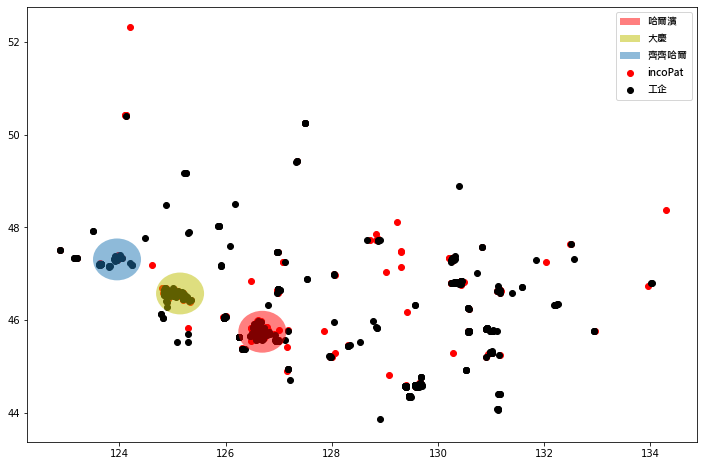

In [6]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(patented['lnt'], patented['lat'],c='r',label='incoPat')
ax.scatter(not_patented['lnt'], not_patented['lat'],c='k',label='工企')
cir1 = Circle(xy = (126.69181, 45.74567), radius=50/110.574,facecolor='r' ,alpha=0.5,label='哈爾濱')
cir2 = Circle(xy = (125.14284, 46.57246), radius=50/110.574,facecolor='y' ,alpha=0.5,label='大慶')
cir3 = Circle(xy = (123.95543, 47.30816), radius=50/110.574, alpha=0.5,label='齊齊哈爾')
ax.add_patch(cir1)
ax.add_patch(cir2)
ax.add_patch(cir3)
ax.legend(loc=1,prop=myfont)

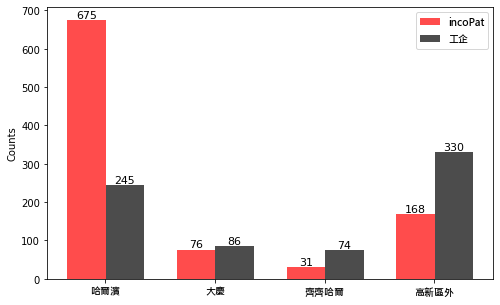

In [7]:
fig = plt.figure(figsize = (8,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Counts')
bar1 = ax1.bar(np.arange(0,4),[len(patented[patented['哈爾濱']==1]),len(patented[patented['大慶']==1]),len(patented[patented['齊齊哈爾']==1]),len(patented[(patented['哈爾濱']==0)&(patented['大慶']==0)&(patented['齊齊哈爾']==0)])],alpha=0.7,width=0.35,color='r',label='incoPat')
bar2 = ax1.bar(np.arange(0,4)+0.35,[len(not_patented[not_patented['哈爾濱']==1]),len(not_patented[not_patented['大慶']==1]),len(not_patented[not_patented['齊齊哈爾']==1]),len(not_patented[(not_patented['哈爾濱']==0)&(not_patented['大慶']==0)&(not_patented['齊齊哈爾']==0)])],alpha=0.7,width=0.35,color='k',label='工企')
for a,b in zip(np.arange(0,4),[len(patented[patented['哈爾濱']==1]),len(patented[patented['大慶']==1]),len(patented[patented['齊齊哈爾']==1]),len(patented[(patented['哈爾濱']==0)&(patented['大慶']==0)&(patented['齊齊哈爾']==0)])]):  
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=11)  
for a,b in zip(np.arange(0,4)+0.35,[len(not_patented[not_patented['哈爾濱']==1]),len(not_patented[not_patented['大慶']==1]),len(not_patented[not_patented['齊齊哈爾']==1]),len(not_patented[(not_patented['哈爾濱']==0)&(not_patented['大慶']==0)&(not_patented['齊齊哈爾']==0)])]):  
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=11) 

plt.xticks([0.17,1.17,2.17,3.17],['哈爾濱','大慶','齊齊哈爾','高新區外'],fontproperties=myfont)
plt.legend(handles = [bar1,bar2], loc='upper right',prop=myfont)